## This notebook will help you train a vanilla Point-Cloud AE with the basic architecture we used in our paper.
    (it assumes latent_3d_points is in the PYTHONPATH and the structural losses have been compiled)

In [126]:
import os.path as osp

import sys
sys.path.append('/home/jcollins')

from latent_3d_points.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params, \
                                              jack_1_template
from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.point_net_ae import PointNetAutoEncoder

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.tf_utils import reset_tf_graph
from latent_3d_points.src.general_utils import plot_3d_point_cloud
import gc

In [127]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [128]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define Basic Parameters

In [129]:
top_out_dir = '../data/'          # Use to save Neural-Net check-points etc.
top_in_dir = '../data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_ae_bneck-100'
n_pc_points = 1000                # Number of points per model.
bneck_size = 100                  # Bottleneck-AE size
ae_loss = 'emd'                   # Loss to optimize: 'emd' or 'chamfer'

Load Point-Clouds

In [130]:
import pandas as pd
numjets = 500000
numvalid = 50000
outstore = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_points.h5")
# rawdata = outstore.select("points",stop=numjets).values
# rawdata = rawdata.reshape(numjets,1000,2)
# all_pc_data = PointCloudDataSet(rawdata,copy=False)
validdata = outstore.select("points",start=numjets,stop=numjets+numvalid).values
validdata = validdata.reshape(numvalid,1000,2)
valid_pc_data = PointCloudDataSet(validdata,copy=False)
gc.collect()

132894

Load default training parameters (some of which are listed beloq). For more details please print the configuration object.

    'batch_size': 50   
    
    'denoising': False     (# by default AE is not denoising)

    'learning_rate': 0.0005

    'z_rotate': False      (# randomly rotate models of each batch)
    
    'loss_display_step': 1 (# display loss at end of these many epochs)
    'saver_step': 10       (# over how many epochs to save neural-network)

In [131]:
train_params = default_train_params()
train_params['saver_step'] = 2
encoder, decoder, enc_args, dec_args = jack_1_template(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

In [132]:
conf = Conf(n_input = [n_pc_points, 2],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
conf.experiment_name = experiment_name
conf.held_out_step = 1   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

In [133]:
load_pre_trained_ae = True
restore_epoch = 120
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)

Building Encoder
encoder_conv_layer_0 conv params =  384 bnorm params =  256
Tensor("single_class_ae_bneck-100_2/Relu:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

encoder_conv_layer_1 conv params =  16512 bnorm params =  256
Tensor("single_class_ae_bneck-100_2/Relu_1:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

Symmetry Layer:
Tensor("single_class_ae_bneck-100_2/Sum:0", shape=(?, 128), dtype=float32) 

encoder_dense_layer_0 FC params =  16512 bnorm params =  256
Tensor("single_class_ae_bneck-100_2/Relu_2:0", shape=(?, 128), dtype=float32)
output size: 128 

encoder_dense_layer_1 FC params =  16512 bnorm params =  256
Tensor("single_class_ae_bneck-100_2/Relu_3:0", shape=(?, 128), dtype=float32)
output size: 128 

encoder_dense_layer_2 FC params =  12900 bnorm params =  200
Tensor("single_class_ae_bneck-100_2/Relu_4:0", shape=(?, 100), dtype=float32)
output size: 100 

Building Decoder
decoder_fc_0 FC params =  25856 Tensor("single_class_ae_bneck-100_2

Get a batch of reconstuctions and their latent-codes.

Use any plotting mechanism such as matplotlib to visualize the results.

In [134]:
import ot
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt

In [135]:
numload = 1000
feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)

In [136]:
def jet_masses(jets, p_norm = 600):
    numpoints = len(jets[0])
    Delta_Rs = np.linalg.norm(feed_pc,axis=2)
#    p_parr = np.sum(np.cos(Delta_Rs),axis=1)
    p_parr = np.sum(np.cos(jets[:,:,0])*np.cos(jets[:,:,1]),axis=1)
    masses = np.sqrt(numpoints**2 - np.power(p_parr,2))*p_norm/numpoints
    return masses

In [137]:
import time
from latent_3d_points.external.structural_losses import tf_approxmatch


print "##### Approx EMD #####"
nclouds = 1
npoints = 1000
ndim=2

points1 = reconstructions[:10]
points2 = feed_pc[:10]

start = time.time()

this = tf_approxmatch.approx_match(points1,points2)
init_op = tf.initialize_all_variables()


#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    transport = sess.run(this)
    #print transport

this_cost = tf_approxmatch.match_cost(points1,points2,transport)
init_op = tf.initialize_all_variables()

#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    cost = sess.run(this_cost)/1000*600
    print np.array(cost)
    
print time.time()-start


print "\n \n \n ##### True EMD #####"
start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])/1000*600
print time.time()-start
print truecost

print "\n \n \n ##### Fractional difference #####"
print (np.array(cost) - np.array(truecost))/np.array(truecost)

##### Approx EMD #####
[46.24652  11.986435 15.372121 24.07767  41.11498  38.526775 33.08373
 46.57413  26.207329 24.984703]
3.75018382072

 
 
 ##### True EMD #####
1.8711950779
[41.22896819 11.11247799 14.48606526 21.99206634 37.71184964 35.10297587
 32.54650084 41.02177462 24.58218314 23.70822625]

 
 
 ##### Fractional difference #####
[0.12169969 0.07864645 0.06116606 0.09483433 0.09024031 0.09753588
 0.01650647 0.13535144 0.06611071 0.05384109]


34.357473494


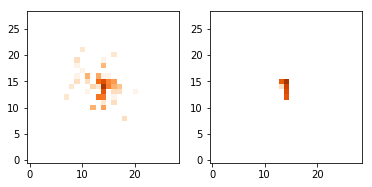

9.260398327


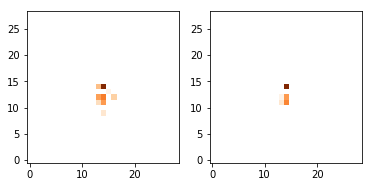

12.0717210474


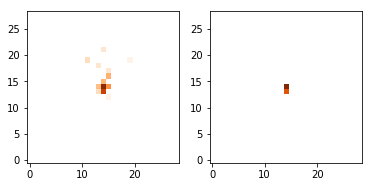

18.3267219473


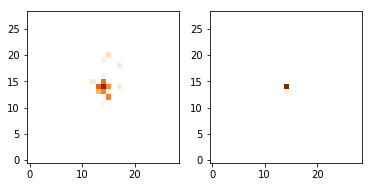

31.4265413688


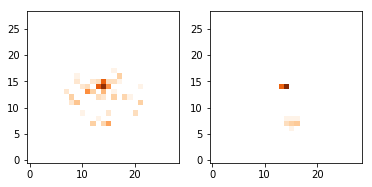

29.2524798898


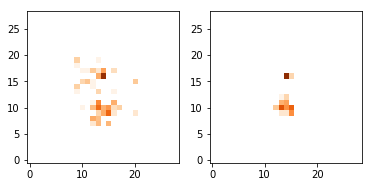

27.1220840326


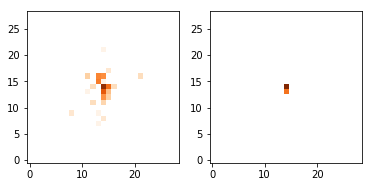

34.1848121838


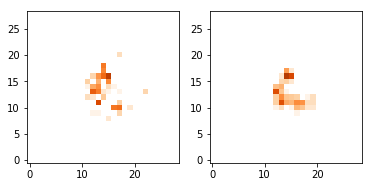

20.4851526138


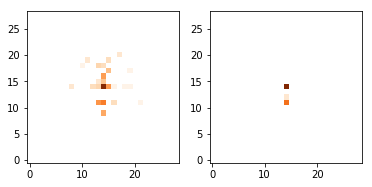

19.7568552046


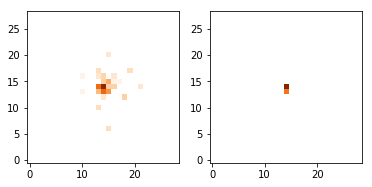

11.2697122804


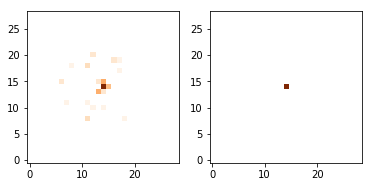

14.5346575484


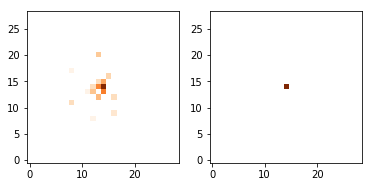

28.2980298571


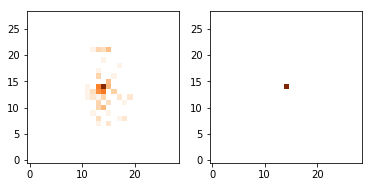

18.2012058004


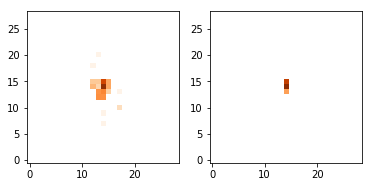

17.4339785736


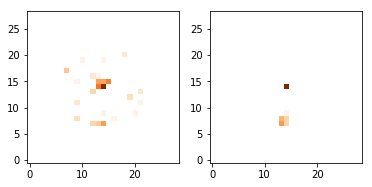

23.3279030237


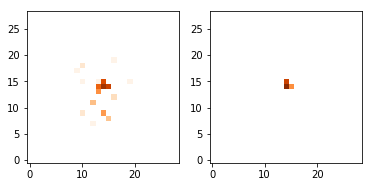

12.7293453284


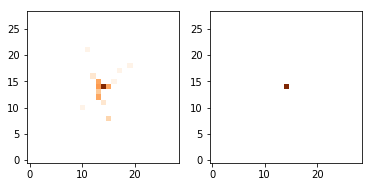

57.390005588


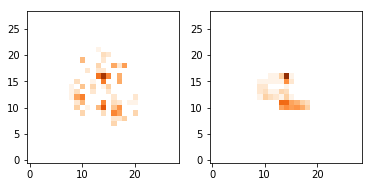

15.4697517197


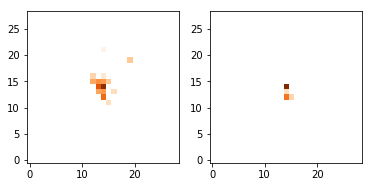

23.1304838211


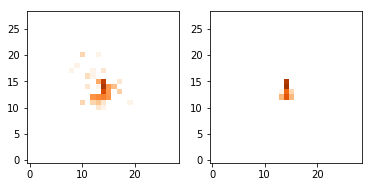

5.5165017834


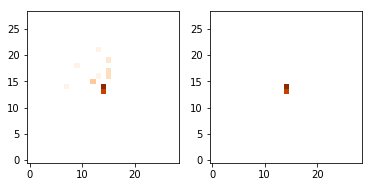

11.4996276203


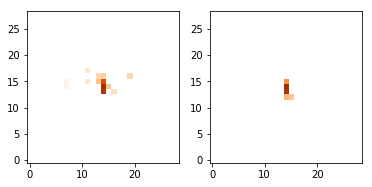

15.646773728


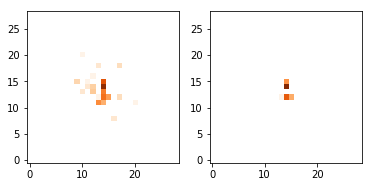

32.9950594991


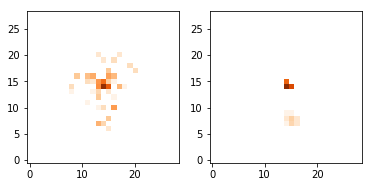

9.77230371335


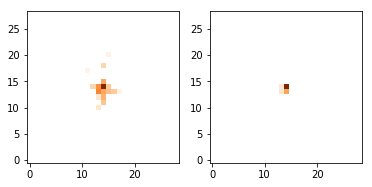

31.1244617972


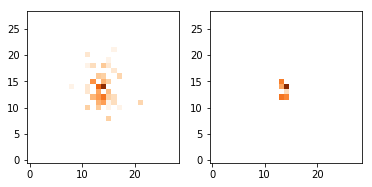

17.6167210746


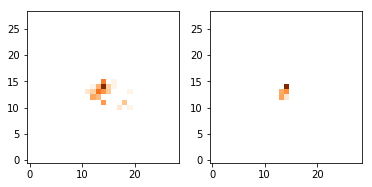

17.0037739191


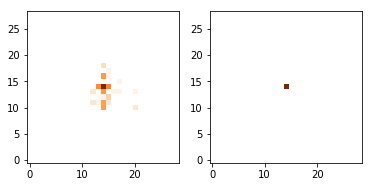

41.2108931588


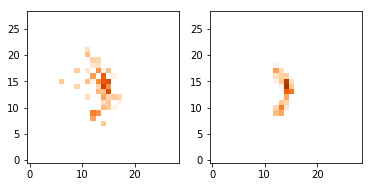

22.4281865952


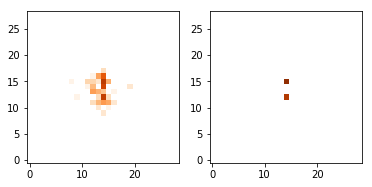

39.2462351983


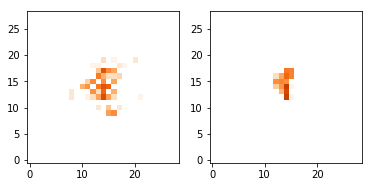

20.9061778006


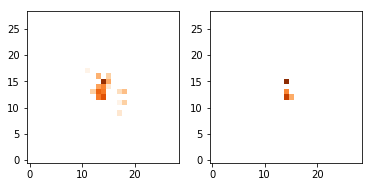

8.01187315492


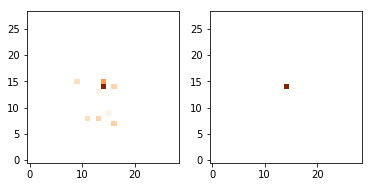

25.2201843134


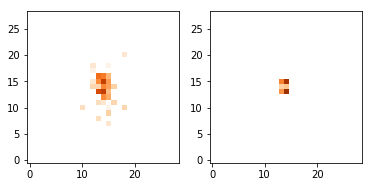

21.4233322306


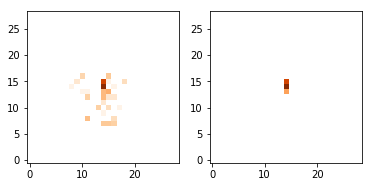

13.6967437926


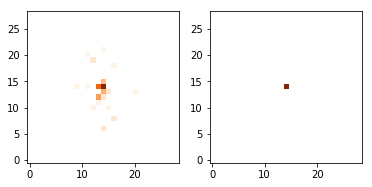

24.3476553773


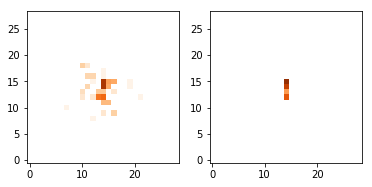

20.3379797619


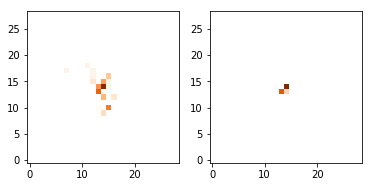

7.15642021855


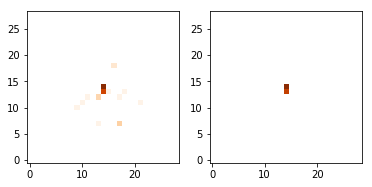

15.8524197334


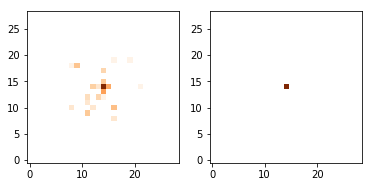

28.8661152862


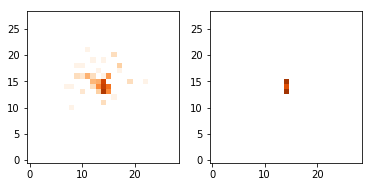

30.1506784265


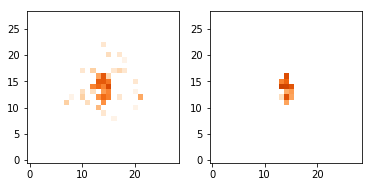

16.2388530462


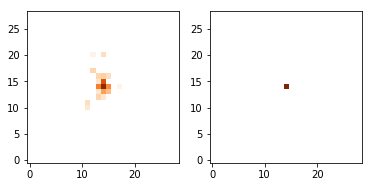

9.20974977697


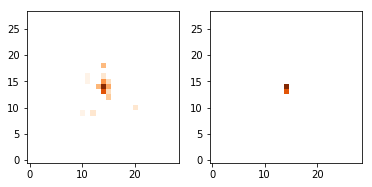

26.0072711987


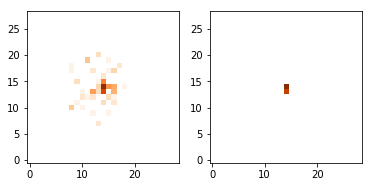

6.498022778


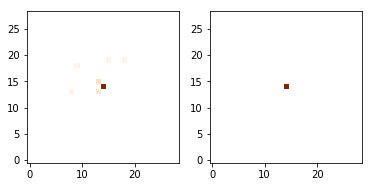

25.3457669056


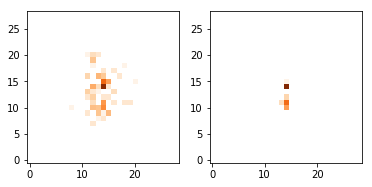

22.2919596189


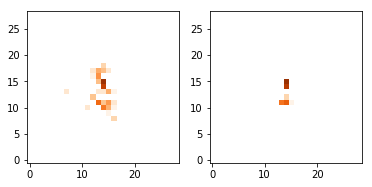

11.5184518134


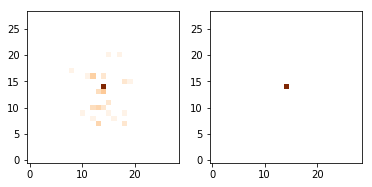

16.713146645


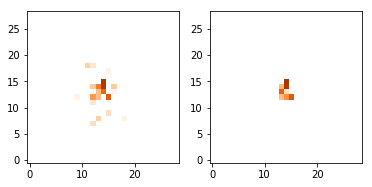

In [138]:
countcut=0.9
lim=1.5
bins=np.linspace(-lim, lim, 30)

#for i in range(len(feed_pc)):
for i in range(50):   

    M = np.sqrt(ot.dist(feed_pc[i],reconstructions[i]))
    truecost = ot.emd2(np.ones(1000),np.ones(1000),M)/1000*500

    print truecost
    
    fig, ax = plt.subplots(1, 2,figsize=[6,3])
    counts, bx, by = np.histogram2d(feed_pc[i][:,0],feed_pc[i][:,1],bins=bins)
    ax[0].imshow(counts.T , norm=LogNorm(countcut, 1000), origin='lower',cmap='Oranges')
    #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
    counts, bx, by = np.histogram2d(reconstructions[i][:,0],reconstructions[i][:,1],bins=bins)
    ax[1].imshow(counts.T, norm=LogNorm(countcut, 1000), origin='lower',cmap='Oranges')
    plt.show()

In [141]:
import time
points1 = reconstructions[:100]
points2 = feed_pc[:100]

start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

qcd_truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])/1000*600
print qcd_truecost
print time.time()-start

print np.average(qcd_truecost)
print np.std(qcd_truecost)

[41.22896819 11.11247799 14.48606526 21.99206634 37.71184964 35.10297587
 32.54650084 41.02177462 24.58218314 23.70822625 13.52365474 17.44158906
 33.95763583 21.84144696 20.92077429 27.99348363 15.27521439 68.86800671
 18.56370206 27.75658059  6.61980214 13.79955314 18.77612847 39.5940714
 11.72676446 37.34935416 21.14006529 20.4045287  49.45307179 26.91382391
 47.09548224 25.08741336  9.61424779 30.26422118 25.70799868 16.43609255
 29.21718645 24.40557571  8.58770426 19.02290368 34.63933834 36.18081411
 19.48662366 11.05169973 31.20872544  7.79762733 30.41492029 26.75035154
 13.82214218 20.05577597 37.09797814 21.60101043 48.20472083 27.05593764
 45.49805789 25.45632964 39.48502376 21.32799469 13.09424235 11.1546664
 27.33814574 41.18439394 20.14202626 41.09942237 11.02698613 18.94821938
  7.82569129 32.70887471 31.33865789 20.71210249 38.79095276 19.32444525
 46.57568602  6.80177581 21.74979496 40.3040627  28.11347457 22.99411451
 15.80365055 16.00511435 10.67508857 38.65816428 16.8

In [142]:
import pandas as pd
numjets = 0
numvalid = 10000
outstore = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_points_top.h5")
topdata = outstore.select("points",start=numjets,stop=numjets+numvalid).values
topdata = topdata.reshape(numvalid,1000,2)
top_pc_data = PointCloudDataSet(topdata,copy=False)
gc.collect()


numload = 1000
top_feed_pc, feed_model_names, _ = top_pc_data.next_batch(numload )
top_reconstructions = ae.reconstruct(top_feed_pc)[0]
top_latent_codes = ae.transform(top_feed_pc)

23.352860987


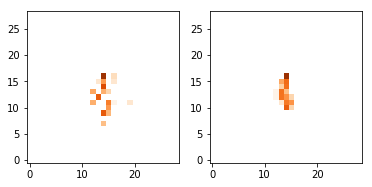

32.7821602185


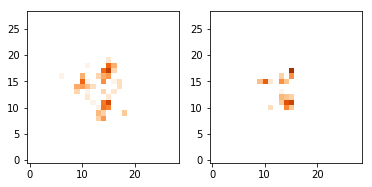

37.0705560507


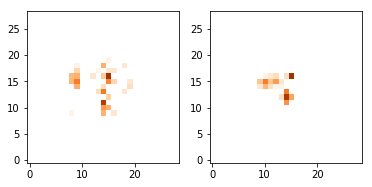

20.2506708137


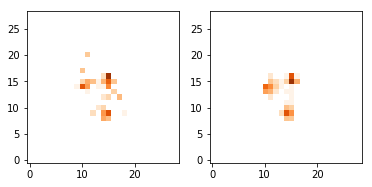

25.1301820552


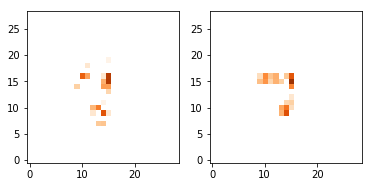

27.0640223333


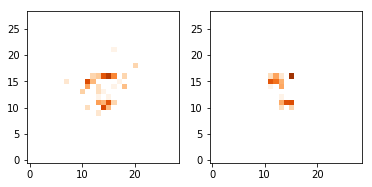

36.9648537255


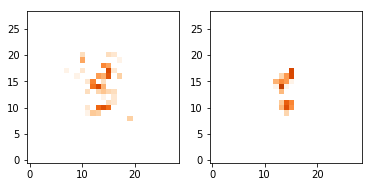

27.0824622753


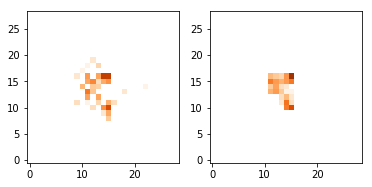

27.4035705172


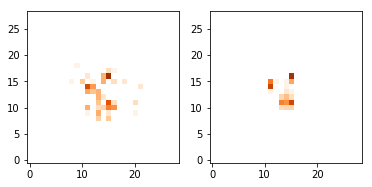

25.1261767634


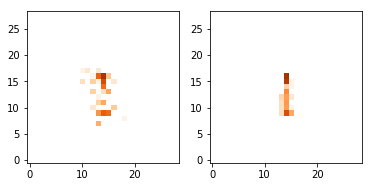

In [143]:
countcut=0.9
lim=1.5
bins=np.linspace(-lim, lim, 30)

#for i in range(len(feed_pc)):
for i in range(10):   

    M = np.sqrt(ot.dist(top_feed_pc[i],top_reconstructions[i]))
    truecost = ot.emd2(np.ones(1000),np.ones(1000),M)/1000*500

    print truecost
    
    fig, ax = plt.subplots(1, 2,figsize=[6,3])
    counts, bx, by = np.histogram2d(top_feed_pc[i][:,0],top_feed_pc[i][:,1],bins=bins)
    ax[0].imshow(counts.T , norm=LogNorm(countcut, 1000), origin='lower',cmap='Oranges')
    #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
    counts, bx, by = np.histogram2d(top_reconstructions[i][:,0],top_reconstructions[i][:,1],bins=bins)
    ax[1].imshow(counts.T, norm=LogNorm(countcut, 1000), origin='lower',cmap='Oranges')
    plt.show()

In [144]:
import time
from latent_3d_points.external.structural_losses import tf_approxmatch


print "##### Approx EMD #####"
nclouds = 1
npoints = 1000
ndim=2

points1 = top_reconstructions[:10]
points2 = top_feed_pc[:10]

start = time.time()

this = tf_approxmatch.approx_match(points1,points2)
init_op = tf.initialize_all_variables()


#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    transport = sess.run(this)
    #print transport

this_cost = tf_approxmatch.match_cost(points1,points2,transport)
init_op = tf.initialize_all_variables()

#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    cost = sess.run(this_cost)/1000*600
    print np.array(cost)
    
print time.time()-start


print "\n \n \n ##### True EMD #####"
start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])/1000*600
print time.time()-start
print truecost

print "\n \n \n ##### Fractional difference #####"
print (np.array(cost) - np.array(truecost))/np.array(truecost)

##### Approx EMD #####
[32.622593 44.395317 49.76927  27.952854 33.770912 35.856655 49.515465
 38.422764 37.755535 37.44501 ]
3.46906805038

 
 
 ##### True EMD #####
1.32176494598
[28.02343318 39.33859226 44.48466726 24.30080498 30.15621847 32.4768268
 44.35782447 32.49895473 32.88428462 30.15141212]

 
 
 ##### Fractional difference #####
[0.16411835 0.12854361 0.11879609 0.15028511 0.11986562 0.10406892
 0.11627352 0.18227691 0.14813308 0.24189909]


In [145]:
import time
points1 = reconstructions[:1000]
points2 = feed_pc[:1000]

start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

qcd_truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])/1000*600
print qcd_truecost
print time.time()-start

print np.average(qcd_truecost)
print np.std(qcd_truecost)

import time
points1 = top_reconstructions[:1000]
points2 = top_feed_pc[:1000]

start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

top_truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])/1000*600
print top_truecost
print time.time()-start

print np.average(top_truecost)
print np.std(top_truecost)

[41.22896819 11.11247799 14.48606526 21.99206634 37.71184964 35.10297587
 32.54650084 41.02177462 24.58218314 23.70822625 13.52365474 17.44158906
 33.95763583 21.84144696 20.92077429 27.99348363 15.27521439 68.86800671
 18.56370206 27.75658059  6.61980214 13.79955314 18.77612847 39.5940714
 11.72676446 37.34935416 21.14006529 20.4045287  49.45307179 26.91382391
 47.09548224 25.08741336  9.61424779 30.26422118 25.70799868 16.43609255
 29.21718645 24.40557571  8.58770426 19.02290368 34.63933834 36.18081411
 19.48662366 11.05169973 31.20872544  7.79762733 30.41492029 26.75035154
 13.82214218 20.05577597 37.09797814 21.60101043 48.20472083 27.05593764
 45.49805789 25.45632964 39.48502376 21.32799469 13.09424235 11.1546664
 27.33814574 41.18439394 20.14202626 41.09942237 11.02698613 18.94821938
  7.82569129 32.70887471 31.33865789 20.71210249 38.79095276 19.32444525
 46.57568602  6.80177581 21.74979496 40.3040627  28.11347457 22.99411451
 15.80365055 16.00511435 10.67508857 38.65816428 16.8

[28.02343318 39.33859226 44.48466726 24.30080498 30.15621847 32.4768268
 44.35782447 32.49895473 32.88428462 30.15141212 33.98028243 38.77354366
 38.09922956 31.12662623 46.84713002 33.86657264 34.4829557  34.21937875
 44.53199366 38.92088148 44.79590958 38.99741212 31.48238563 34.60458933
 26.76625489 47.39391309 34.51597356 33.83449423 28.88974045 30.80255964
 29.61748457 40.07499771 28.36986012 44.13601347 42.16388482 45.87824294
 48.42153167 31.68939673 47.21777058 31.72359674 29.78796641 38.59247026
 39.59057372 30.53827635 31.18449688 26.74407085 37.75443282 42.99568149
 43.73891389 25.2229095  46.28537122 44.05761179 20.50858993 50.15791151
 40.40617716 41.31483338 17.33385619 34.54517523 47.695302   26.63787122
 43.18707771 26.78046861 36.35896675 34.42021196 33.31846481 30.74926986
 40.51221386 47.46878854 40.80017547 43.59165946 41.17718677 35.15785767
 28.68555795 31.52075748 27.36656271 30.47555186 30.27880526 33.82023271
 41.90078643 40.72124076 27.25030842 29.70204407 27.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys


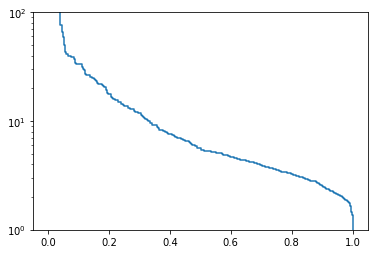

In [146]:
from sklearn.metrics import roc_curve

y_true = np.append(np.zeros(len(qcd_truecost)),np.ones(len(top_truecost)))
y_score = np.append(qcd_truecost, top_truecost)
my_roc = roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)

plt.plot(my_roc[1],np.nan_to_num(1/my_roc[0]))
plt.ylim([1,10**2])
plt.semilogy()
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in divide
  # Remove the CWD from sys.path while we load stuff.


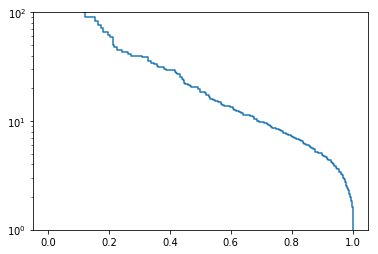

In [110]:



from sklearn.metrics import roc_curve

y_true = np.append(np.zeros(len(qcd_truecost)),np.ones(len(top_truecost)))
y_score = np.append(qcd_truecost, top_truecost)
my_roc = roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)

plt.plot(my_roc[1],np.nan_to_num(1/my_roc[0]))
plt.ylim([1,10**2])
plt.semilogy()
plt.show()

In [46]:
import time
numload = 1000
feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)
points1 = reconstructions[:1000]
#points1 = feed_pc[:1000]
latent_codes = ae.transform(feed_pc[:1000])

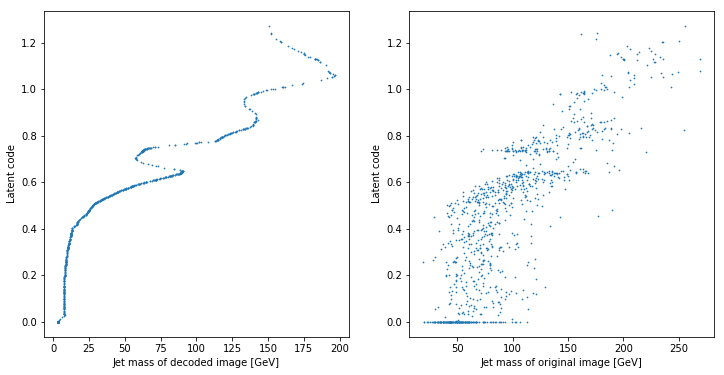

In [58]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.scatter(jet_masses(reconstructions[:1000]),latent_codes,s=0.5)
plt.xlabel('Jet mass of decoded image [GeV]')
plt.ylabel('Latent code')
plt.subplot(1,2,2)
plt.scatter(jet_masses(feed_pc[:1000]),latent_codes,s=0.5)
plt.xlabel('Jet mass of original image [GeV]')
plt.ylabel('Latent code')
plt.show()

In [ ]:
plt.figure(figsize=[10,10])
plt.scatter(jet_masses(reconstructions[:1000]),latent_codes,s=0.5)
plt.xlabel('Jet mass of decoded image [GeV]')
plt.ylabel('Latent code')
plt.show()

In [63]:
latent_codes

array([[0.00000000e+00],
       [0.00000000e+00],
       [5.81276476e-01],
       [1.26240134e+00],
       [3.47610474e-01],
       [1.75073600e+00],
       [1.39840186e-01],
       [1.92238939e+00],
       [3.10518295e-01],
       [1.17008245e+00],
       [3.96468550e-01],
       [7.54160583e-02],
       [4.76377696e-01],
       [0.00000000e+00],
       [2.68678188e-01],
       [6.89374804e-01],
       [0.00000000e+00],
       [8.80986333e-01],
       [0.00000000e+00],
       [1.44568950e-01],
       [2.33953893e-01],
       [3.62116545e-01],
       [0.00000000e+00],
       [7.80828893e-02],
       [1.66362613e-01],
       [2.27818418e+00],
       [2.96546161e-01],
       [0.00000000e+00],
       [2.14791155e+00],
       [9.05103624e-01],
       [0.00000000e+00],
       [1.44773412e+00],
       [1.10544348e+00],
       [6.39003396e-01],
       [2.02482671e-01],
       [0.00000000e+00],
       [8.25659990e-01],
       [7.49899149e-01],
       [8.32780004e-01],
       [1.34153813e-01],


In [74]:
numload = 10000
feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
feed_pc[0]

array([[ 0.017118  ,  0.19660918],
       [ 0.017118  ,  0.19660918],
       [ 0.017118  ,  0.19660918],
       ...,
       [-0.3880499 , -0.32016189],
       [ 0.01924656,  0.57144681],
       [ 0.63545814,  0.64884996]])

In [69]:
numpoints = len(jets[0])
Delta_Rs = np.linalg.norm(feed_pc,axis=2)
#    p_parr = np.sum(np.cos(Delta_Rs),axis=1)
np.sum(np.sin(jets[:,:,1]),axis=1)*600/1000

array([ 1.04154646, -1.01855432,  0.82381232,  2.8626084 ,  4.66926383,
        0.44145631, -0.78976928,  0.42520581, -0.56581046,  7.00944821,
       -0.0294308 , -1.07126786, -1.61526932, -0.52807492, -0.11218356,
       12.31053926, -1.94153188, -0.13629966,  1.2301602 , -1.22495414,
        1.48715351,  0.66155514, -0.25137587,  0.2585713 ,  0.59379215,
        0.61316492,  3.14910778,  0.09642428, 12.5186531 ,  0.95693838,
        1.4083551 ,  0.16460985, -0.01416972,  1.16919155, -0.13955238,
       -0.5423792 , -0.71587804,  0.51078518,  0.19862528, -0.3253633 ,
        6.62082248,  3.83881109, -0.72389678, -0.05940396,  3.14886234,
       -0.53045421,  0.09860626,  0.27655945,  0.23807206, -2.60423897,
        0.73574803,  0.37317332,  1.43749019, -0.45112478, -0.37274221,
        0.76862296,  3.13978595,  0.17130608, -0.19702835,  2.82923504,
        0.23081686, -0.2364088 ,  6.86463026,  1.0664655 ,  0.46326879,
        2.82499946,  0.27885064,  3.50456043,  2.10245745,  1.76

In [71]:
jets[:,:,0]

array([[ 0.01869681,  0.01869681,  0.01869681, ..., -0.23907139,
        -0.09400195, -0.65201326],
       [ 0.01031599,  0.01031599,  0.01031599, ...,  0.03088808,
         0.28167166,  0.82886674],
       [ 0.00961767,  0.00961767,  0.00961767, ...,  0.17601627,
        -0.60450113, -0.11882481],
       ...,
       [ 0.00723219,  0.00723219,  0.00723219, ...,  0.24995147,
         0.08002635, -0.34747694],
       [ 0.03372887,  0.03372887,  0.03372887, ...,  0.01355405,
         0.27136203,  0.16863137],
       [ 0.01648945,  0.01648945,  0.01648945, ...,  0.48698032,
         0.45907187,  0.58905874]])

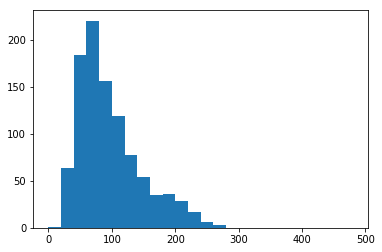

In [32]:
plt.hist(jet_masses(feed_pc), bins=np.arange(0,500,20))
plt.show()

In [42]:
jets = feed_pc
numpoints = len(jets[0])
Delta_Rs = np.linalg.norm(feed_pc,axis=2)
p_parr = np.sum(np.cos(Delta_Rs))
masses = np.sqrt(numpoints**2 - np.power(p_parr,2))*p_norm/numpoints

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


In [44]:
p_parr

96376.95345754223

In [60]:
np.cos(3.14)

-0.9999987317275395

In [102]:
numload = 1000
feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
#reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)

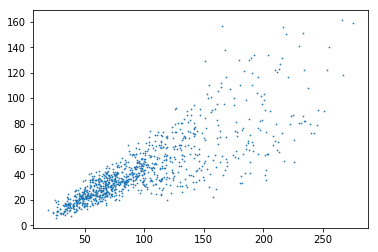

In [34]:
jet_masses(feed_pc[(latent_codes ==0.).flatten()])

array([ 35.28688225,  93.1821818 ,  68.674639  ,  66.82980052,
        74.14441173,  34.51399374,  69.14875579,  36.95418762,
        58.10141722,  35.03645862,  59.17256632,  46.93591623,
        65.7136201 ,  58.5225264 ,  49.73832894,  41.92313558,
        81.62550544,  81.31715223,  61.86501389,  70.09262545,
        55.00411739,  50.09787022,  56.01598295,  41.08508213,
        37.45209645,  26.12286477,  46.64123251,  33.62808724,
        76.62201858,  59.6882946 ,  97.54313234,  61.19816435,
        27.00050637,  52.88769576,  93.3634272 ,  69.40321466,
        32.31190283,  47.50241584,  80.27918911,  80.08367439,
        86.4246068 ,  59.84014424,  73.06503657,  35.90446185,
        70.4502928 ,  52.35135732,  62.28219444,  27.45181723,
        56.91367661,  37.44571713,  43.88163728,  56.53454517,
        91.66736612,  48.45572223,  55.14218424,  26.93894511,
        59.53523344,  90.1539713 ,  43.64649611,  49.89533825,
        65.84580757,  42.11258539,  97.3171227 ,  45.04

In [83]:
latent_codes[latent_codes ==0.][0]

0.0

In [85]:
(latent_codes ==0.)

array([[ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [